##Modelo de Machine Learning Hackaton

La nota predicha para el alumno es: 0.99 (Aprobado)

Sugerencias de mejora basadas en SHAP (máximo 5):
- Importancia para ti de tus notas: Valor actual del alumno -> 2.0.
- Te aseguras de comprender completamente el enunciado de la practica antes de comenzar a trabajar en ella: Valor actual del alumno -> 3.0.
- Te formulas preguntas al estudiar: Valor actual del alumno -> 1.0.
- Cuando preparas un examen repasas y estudias apuntes de clase: Valor actual del alumno -> 2.0.
- Te informas de cómo va a ser el examen tipo de preguntas…: Valor actual del alumno -> 1.0.


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


Error cuadrático medio (MSE): 0.1323658536585366
Coeficiente de Determinación (R²): 0.889752508361204
Mean Absolute Error (MAE): 0.2648780487804878
Root Mean Squared Error (RMSE): 0.3638211836308279


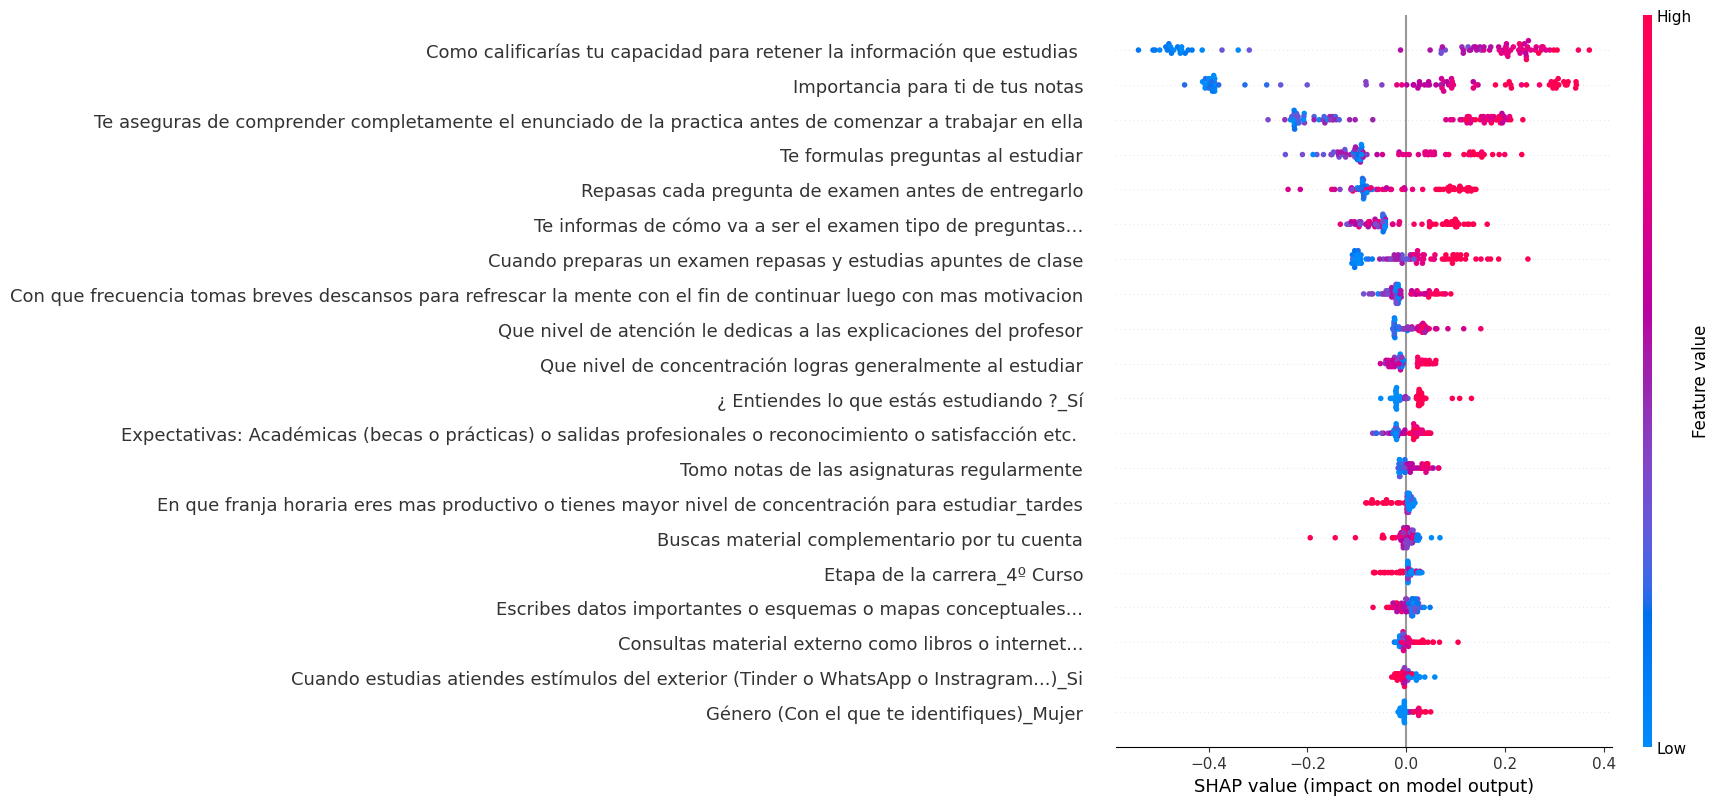

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import shap
import numpy as np

# Leemos el csv
data = pd.read_csv('DATOSJAKATON.csv')

# Convertimos variables categóricas a numéricas mediante mapping o One-Hot Encoding
nota_mapping = {'Suspenso': 0, 'Aprobado': 1, 'Notable': 2, 'Sobresaliente': 3, 'Matrícula de Honor': 4}
data['nota_num'] = data['Nota media en el curso'].map(nota_mapping)

data_clean = data.drop(columns=['Marca temporal', 'Nota media en el curso', 'nota_num'])
data_encoded = pd.get_dummies(data_clean, drop_first=True)

# Rellenamos los NaN que hayan quedado
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(data_encoded)

# Recogemos los datos que vamos a usar en el modelo, separando las variables y la nota que queremos predecir
X = pd.DataFrame(X_imputed, columns=data_encoded.columns)
y = data['nota_num']

# Aplicamos SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividimos en entrenamiento y prueba para entrenar al Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

def interpretar_nota(nota_predicha):
    if nota_predicha < 0.5:
        return "Suspenso"
    elif nota_predicha < 1.5:
        return "Aprobado"
    elif nota_predicha < 2.5:
        return "Notable"
    elif nota_predicha < 3.5:
        return "Sobresaliente"
    else:
        return "Matrícula de Honor"

def predecir_nota_alumno_shap(caracteristicas_alumno):
    alumno_df = pd.DataFrame([caracteristicas_alumno], columns=X.columns)

    nota_predicha = model.predict(alumno_df)[0]
    nota_interpretada = interpretar_nota(nota_predicha)

    print(f"La nota predicha para el alumno es: {nota_predicha:.2f} ({nota_interpretada})")

    # Generamos los valores SHAP para este estudiante en concreto
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(alumno_df)

    # Guardamos juntos el nombre de la variable, el valor del alumno para ella y el valor SHAP que le asociaremos
    shap_df = pd.DataFrame({
        'Característica': X.columns,
        'Valor actual': alumno_df.iloc[0],
        'Valor SHAP': shap_values[0]
    })

    # Cogemos solo las características con valores SHAP negativos, es decir, que reducen la nota
    shap_negativo = shap_df[(shap_df['Valor SHAP'] < 0) & (~shap_df['Valor actual'].isna())]

    # Ordenamos los valores SHAP por los más negativos y cogemos solo los primeros 5
    shap_negativo = shap_negativo.sort_values(by='Valor SHAP')
    sugerencias = shap_negativo.head(5)

    if not sugerencias.empty:
        print("\nSugerencias de mejora basadas en SHAP (máximo 5):")
        for _, row in sugerencias.iterrows():
            print(f"- {row['Característica']}: Valor actual del alumno -> {row['Valor actual']}.")
    else:
        print("\nNo hay sugerencias de mejora, todas las características tienen un impacto positivo o no se encontraron valores significativos.")


caracteristicas_alumno = {
    'Importancia para ti de tus notas': 2,
    'Repasas cada pregunta de examen antes de entregarlo': 6,
    'Expectativas: Académicas (becas o prácticas) o salidas profesionales o reconocimiento o satisfacción etc.': 2,
    'Te informas de cómo va a ser el examen tipo de preguntas…': 1,
    'Que nivel de atención le dedicas a las explicaciones del profesor': 4,
    'Como calificarías tu capacidad para retener la información que estudias': 3,
    'Tomo notas de las asignaturas regularmente': 2,
    'Buscas material complementario por tu cuenta': 1,
    'Repasas el temario': 2,
    'Utilizas métodos de planificación de estudio': 4,
    'Escribes datos importantes o esquemas o mapas conceptuales...': 3,
    'Con que frecuencia tomas breves descansos para refrescar la mente con el fin de continuar luego con mas motivacion': 4,
    'Cuantas horas dedicas a estudiar a la semana': 10,
    'Con que frecuencia cumples los tiempos de estudio propuestos': 2,
    'Lees todo el examen antes de comenzar a resolverlo': 3,
    'Te aseguras de comprender completamente el enunciado de la practica antes de comenzar a trabajar en ella': 3,
    'Te formulas preguntas al estudiar': 1,
    'Cuando preparas un examen repasas y estudias apuntes de clase': 2,
    '¿ Entiendes lo que estás estudiando ?_Sí': 1,
    '¿ Entiendes lo que estás estudiando ?_Tal vez': 0,
    'Etapa de la carrera_2º Curso': 1,
    'Etapa de la carrera_3º Curso': 0,
    'Etapa de la carrera_4º Curso': 0,
    'Etapa de la carrera_Mitad de tu grado': 0,
    'Nivel de ansiedad al realizar un examen _Bajo o nulo': 0,
    'Nivel de ansiedad al realizar un examen _Medio': 1,
    'Nivel de ansiedad al realizar un examen _PÁNICO!!!': 0,
    'Motivación principal para estar cursando Ingeniería Informática o doble grado..._Prestigio': 1,
    'Motivación principal para estar cursando Ingeniería Informática o doble grado..._Remuneración económica': 0,
    'Motivación principal para estar cursando Ingeniería Informática o doble grado..._Está de moda': 0,
    'Motivación principal para estar cursando Ingeniería Informática o doble grado..._No quedaba otra (padres o notas de corte etc)': 0,
    'Motivación principal para estar cursando Ingeniería Informática o doble grado..._Vocación': 1,
    'Cuando estudias atiendes estímulos del exterior (Tinder o WhatsApp o Instragram...)': 6,
    'Género (Con el que te identifiques)_Mujer': 0,
    'Género (Con el que te identifiques)_Otro': 0,
}

predecir_nota_alumno_shap(caracteristicas_alumno)

# Análisis de importancia global de características usando SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualizar importancia global de las características
shap.summary_plot(shap_values, X_test, show=False)


#################################
# Datos sobre metricas
#################################

# Hacemos predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio (MSE): {mse}")



from sklearn.metrics import r2_score

# Calculo del R²
r2 = r2_score(y_test, y_pred)

print(f"Coeficiente de Determinación (R²): {r2}")

#Calculo MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")

# Calculo RMSE
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")